<a href="https://colab.research.google.com/github/cjstahoviak/Solar-Weather-Lab-Predicting-Sunspot-Activity/blob/main/Copy_of_AdvML_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solar Weather Lab: Predicting Sunspot Activity

## Preprocessing Steps
The following preprocessing steps are taken:
- Data is requested directly from NOAA at [this url](https://services.swpc.noaa.gov/json/solar-cycle/sunspots.json). It comes in JSON format.
- JSON is converted into a Pandas DataFrame.
- The DTypes of the DataFrame are fixed
- Normalize data with **MinMaxScaler**
- Create dataset by creating subsequences of original dataset

In the end we arrive at two DataLoaders, one for training and one for test/evaluation. They are derived from TensorDataset and a given batch size. The train set is shuffled

In [1]:
# REQUEST DATA
import requests

url = "https://services.swpc.noaa.gov/json/solar-cycle/sunspots.json"
response = requests.get(url)

if response.status_code == 200:
    raw_data = response.json()
else:
    print(f"Error {response.status_code}: Unable to fetch data")
    raw_data = []

In [2]:
# CONVERT TO DATAFRAME
import pandas as pd

df = pd.DataFrame(raw_data)
df

,time-tag,ssn
0,1749-01,96.7
1,1749-02,104.3
2,1749-03,116.7
3,1749-04,92.8
4,1749-05,141.7
...,...,...
3309,2024-10,166.4
3310,2024-11,152.5
3311,2024-12,154.5
3312,2025-01,137.0


In [3]:
# FIX DTYPES
df['time-tag'] = pd.to_datetime(df['time-tag']) # Convert to datetime
df.set_index('time-tag', inplace=True) # Set 'time-tag' as index
df = df[['ssn']]  # Keep only 'ssn' column
df.head()

,ssn
time-tag,
1749-01-01,96.7
1749-02-01,104.3
1749-03-01,116.7
1749-04-01,92.8
1749-05-01,141.7


In [4]:
# SPLIT DATA INTO TRAIN AND TEST
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size].copy()
df_test = df.iloc[train_size:].copy()

### Normalize Data
The **MinMaxScaler** transforms our data so that each feature is scaled to fit in a specific range, by default that is $[0,1]$. Each value is scaled using the following equation:
$$x_{\text{new}} = \frac{x - \text{min}}{\text{max} - \text{min}}$$

In [5]:
# NORMALIZE DATA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_train.loc[:, df_train.columns] = scaler.fit_transform(df_train.loc[:, df_train.columns])
df_test.loc[:, df_test.columns] = scaler.transform(df_test.loc[:, df_test.columns])

In [6]:
# CREATE DATASET OF SEQUENCES

from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np

# Sequence Data Preparation
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels), 

sequence_length = 48  # Using past 48 timesteps
data_train_array = df_train.values
data_test_array = df_test.values
X_train, y_train = create_sequences(data_train_array, sequence_length)
X_test, y_test = create_sequences(data_test_array, sequence_length)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False, drop_last=True)

In [7]:
for X_batch, y_batch in train_loader:
    print('Shape of X:', X_batch.shape) 
    print('Shape of y:', y_batch.shape)
    break

# Our X_batch has shape (64, 48, 1) which means we have 64 sequences in a batch, each sequence has 48 timesteps, and each timestep has 1 feature.
# Our y_batch has shape (64, 1) which means we have 64 sequences in a batch, and each sequence has 1 label.

Shape of X: torch.Size([64, 48, 1])
Shape of y: torch.Size([64, 1])


## Training & Evaluation
Below four different types of models are defined, trained, and evaluated:
- Simple Recurrent Neural Network
- Long Short Term Memory Model

### Helper Functions

In [8]:
import matplotlib.pyplot as plt
import time

global_learning_rate = 0.0005
global_hidden_size = 64
global_num_layers = 3
global_epochs = 30

# Training Loop
def train_model(model, train_loader, test_loader, epochs=global_epochs):
    train_loss_history = []  # List to store the average training loss per epoch
    test_loss_history = []   # List to store the average test (validation) loss per epoch
    start_time = time.time()  # Start time measurement

    print_once = False
    
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        total_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)

            if not print_once:
                print_once = True
                print(f"x_batch shape:     {X_batch.shape}")
                print(f"predictions shape: {predictions.shape}")
                print(f"y_batch shape:     {y_batch.shape}")
                
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)
        
        # --- Testing/Validation Phase ---
        model.eval()
        total_test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_history.append(avg_test_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}")
        
    train_time = time.time() - start_time  # Total training time
    return train_time, train_loss_history, test_loss_history

# Testing loop
def evaluate(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch).numpy()
            predictions.extend(preds)
            actuals.extend(y_batch.numpy())
    return np.array(predictions), np.array(actuals)

def average_evaluation_time(model, test_loader, runs=100):
    total_time = 0.0
    for _ in range(runs):
        model.eval()
        predictions, actuals = [], []
        start_time = time.time()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = model(X_batch).numpy()
                predictions.extend(preds)
                actuals.extend(y_batch.numpy())
        total_time += time.time() - start_time
    return total_time / runs

def plot_results(y_true, y_pred, feature_idx=0):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, feature_idx], label="Actual", linestyle="dashed")
    plt.plot(y_pred[:, feature_idx], label="Predicted")
    plt.legend()
    plt.title(f"Feature {df.columns[feature_idx]} Prediction")
    plt.show()

### Simple Recurrent Neural Network (RNN) Model
Requirements:
   - Implement a single-layer RNN to process seismic time-series data.
   - Train and evaluate performance.

In [9]:
# DEFINE MODEL

import torch.nn as nn
import torch

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # The RNN returns output for all timesteps; we take the last timestep's output.
        rnn_out, _ = self.rnn(x)
        return self.fc(rnn_out[:, -1, :])
    
rnn_model = RNNModel(input_dim=df.shape[1], hidden_dim=64, output_dim=df.shape[1])
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

rnn_train_time, rnn_train_loss_history, rnn_test_loss_history = train_model(rnn_model, train_loader, test_loader)
rnn_y_pred, y_true = evaluate(rnn_model, test_loader)
rnn_eval_time = average_evaluation_time(rnn_model, test_loader)

x_batch shape:     torch.Size([64, 48, 1])
predictions shape: torch.Size([64, 1])
y_batch shape:     torch.Size([64, 1])
Epoch 1/30 | Train Loss: 0.012829 | Test Loss: 0.004448
Epoch 2/30 | Train Loss: 0.005799 | Test Loss: 0.003901
Epoch 3/30 | Train Loss: 0.005109 | Test Loss: 0.003714
Epoch 4/30 | Train Loss: 0.005097 | Test Loss: 0.003781
Epoch 5/30 | Train Loss: 0.005128 | Test Loss: 0.003542
Epoch 6/30 | Train Loss: 0.004948 | Test Loss: 0.003766
Epoch 7/30 | Train Loss: 0.004804 | Test Loss: 0.003563
Epoch 8/30 | Train Loss: 0.004772 | Test Loss: 0.003974
Epoch 9/30 | Train Loss: 0.004923 | Test Loss: 0.003451
Epoch 10/30 | Train Loss: 0.004632 | Test Loss: 0.003774
Epoch 11/30 | Train Loss: 0.004557 | Test Loss: 0.003513
Epoch 12/30 | Train Loss: 0.004430 | Test Loss: 0.003751
Epoch 13/30 | Train Loss: 0.004575 | Test Loss: 0.003419
Epoch 14/30 | Train Loss: 0.004624 | Test Loss: 0.003515
Epoch 15/30 | Train Loss: 0.004707 | Test Loss: 0.003342
Epoch 16/30 | Train Loss: 0.00454

### Long-Short Term Memory (LSTM) Model
Requirements: 
   - Implement an LSTM-based model to capture long-range dependencies.
   - Compare results with the simple RNN model.

This model was provided.

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

lstm_model = LSTMModel(input_dim=df.shape[1], hidden_dim=64, output_dim=df.shape[1])
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

lstm_train_time, lstm_train_loss_history, lstm_test_loss_history = train_model(lstm_model, train_loader, test_loader)
lstm_y_pred, y_true = evaluate(lstm_model, test_loader)
lstm_eval_time = average_evaluation_time(lstm_model, test_loader)

x_batch shape:     torch.Size([64, 48, 1])
predictions shape: torch.Size([64, 1])
y_batch shape:     torch.Size([64, 1])
Epoch 1/30 | Train Loss: 0.027624 | Test Loss: 0.012221
Epoch 2/30 | Train Loss: 0.009102 | Test Loss: 0.005526
Epoch 3/30 | Train Loss: 0.006372 | Test Loss: 0.004490
Epoch 4/30 | Train Loss: 0.005756 | Test Loss: 0.004277
Epoch 5/30 | Train Loss: 0.005742 | Test Loss: 0.003980
Epoch 6/30 | Train Loss: 0.005354 | Test Loss: 0.004422
Epoch 7/30 | Train Loss: 0.005150 | Test Loss: 0.004109
Epoch 8/30 | Train Loss: 0.005144 | Test Loss: 0.003954
Epoch 9/30 | Train Loss: 0.004956 | Test Loss: 0.004042
Epoch 10/30 | Train Loss: 0.004862 | Test Loss: 0.003788
Epoch 11/30 | Train Loss: 0.005062 | Test Loss: 0.003903
Epoch 12/30 | Train Loss: 0.004700 | Test Loss: 0.003607
Epoch 13/30 | Train Loss: 0.004750 | Test Loss: 0.003963
Epoch 14/30 | Train Loss: 0.004976 | Test Loss: 0.003546
Epoch 15/30 | Train Loss: 0.004632 | Test Loss: 0.003928
Epoch 16/30 | Train Loss: 0.00465

### Gated Recurrent Unit (GRU)
Requirements:
   - Implement a GRU model and analyze its efficiency in training and generalization.

In [11]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # GRU returns outputs for all timesteps; we select the last timestep's output
        gru_out, _ = self.gru(x)
        return self.fc(gru_out[:, -1, :])

gru_model = GRUModel(input_dim=df.shape[1], hidden_dim=32, output_dim=df.shape[1])
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

gru_train_time, gru_train_loss_history, gru_test_loss_history = train_model(gru_model, train_loader, test_loader)
gru_y_pred, y_true = evaluate(gru_model, test_loader)
gru_eval_time = average_evaluation_time(gru_model, test_loader)

x_batch shape:     torch.Size([64, 48, 1])
predictions shape: torch.Size([64, 1])
y_batch shape:     torch.Size([64, 1])
Epoch 1/30 | Train Loss: 0.019288 | Test Loss: 0.007375
Epoch 2/30 | Train Loss: 0.007510 | Test Loss: 0.005133
Epoch 3/30 | Train Loss: 0.006521 | Test Loss: 0.004647
Epoch 4/30 | Train Loss: 0.006283 | Test Loss: 0.004427
Epoch 5/30 | Train Loss: 0.005918 | Test Loss: 0.004405
Epoch 6/30 | Train Loss: 0.005677 | Test Loss: 0.004344
Epoch 7/30 | Train Loss: 0.005500 | Test Loss: 0.004094
Epoch 8/30 | Train Loss: 0.005303 | Test Loss: 0.003938
Epoch 9/30 | Train Loss: 0.005150 | Test Loss: 0.003748
Epoch 10/30 | Train Loss: 0.005117 | Test Loss: 0.003732
Epoch 11/30 | Train Loss: 0.005102 | Test Loss: 0.003590
Epoch 12/30 | Train Loss: 0.004901 | Test Loss: 0.003555
Epoch 13/30 | Train Loss: 0.004772 | Test Loss: 0.003474
Epoch 14/30 | Train Loss: 0.004829 | Test Loss: 0.003385
Epoch 15/30 | Train Loss: 0.004747 | Test Loss: 0.003318
Epoch 16/30 | Train Loss: 0.00457

### MAMBA
For MAMBA we use this [this github](https://github.com/alxndrTL/mamba.py) implementation using PyTorch.

In [12]:
# IMPORT MAMBA

import torch
import torch.nn as nn
import torch.nn.functional as F

from mambapy.mamba import Mamba, MambaConfig

device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
# CREATE MAMBA MODEL CONFIG

config = MambaConfig(
    d_model=1,    # match the dimension of your input features
    n_layers=2,             # choose how many layers you want
)

mamba_model = Mamba(config).to(device)
optimizer = torch.optim.Adam(mamba_model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # For a regression-style training loop

# Print config parameters
print(config)

MambaConfig(d_model=1, n_layers=2, dt_rank=1, d_state=16, expand_factor=2, d_conv=4, dt_min=0.001, dt_max=0.1, dt_init='random', dt_scale=1.0, rms_norm_eps=1e-05, base_std=0.02, bias=False, conv_bias=True, inner_layernorms=False, mup=False, mup_base_width=128, pscan=True, use_cuda=False)


In [14]:
# TRAIN MAMBA MODEL

mamba_train_loss_history = []  # List to store the average training loss per epoch
mamba_test_loss_history = []   # List to store the average test (validation) loss per epoch
start_time = time.time()  # Start time measurement
epochs = 30
print_once = False

for epoch in range(epochs):
    # --- Training Phase ---
    mamba_model.train()
    total_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = mamba_model(X_batch)
        loss = criterion(predictions[:, -1, :], y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        if not print_once:
            print_once = True
            print(f"x_batch shape: {X_batch.shape}")
            print(X_batch[:3, :3, :])
            print(f"predictions (many) shape: {predictions.shape}")
            print(predictions[:3, :3, :])
            print(f"predictions (one) shape: {predictions.shape}")
            print(predictions[:, -1, :][:3, :])
            print(f"y_batch shape: {y_batch.shape}")
            print(y_batch[:3, :])
            print(f"loss: {loss.item()}")

    avg_train_loss = total_train_loss / len(train_loader)
    mamba_train_loss_history.append(avg_train_loss)
    
    # --- Testing/Validation Phase ---
    mamba_model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = mamba_model(X_batch)
            loss = criterion(predictions[:, -1, :], y_batch)
            total_test_loss += loss.item()
    avg_test_loss = total_test_loss / len(test_loader)
    mamba_test_loss_history.append(avg_test_loss)
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}")
    
mamba_train_time = time.time() - start_time  # Total training time

x_batch shape: torch.Size([64, 48, 1])
tensor([[[0.1047],
         [0.0844],
         [0.1306]],

        [[0.0316],
         [0.0058],
         [0.0264]],

        [[0.1652],
         [0.2853],
         [0.1449]]])
predictions (many) shape: torch.Size([64, 48, 1])
tensor([[[0.1322],
         [0.1095],
         [0.1755]],

        [[0.0590],
         [0.0287],
         [0.0715]],

        [[0.1927],
         [0.3104],
         [0.1898]]], grad_fn=<SliceBackward0>)
predictions (one) shape: torch.Size([64, 48, 1])
tensor([[0.4723],
        [0.7316],
        [0.4041]], grad_fn=<SliceBackward0>)
y_batch shape: torch.Size([64, 1])
tensor([[0.3935],
        [0.7120],
        [0.3400]])
loss: 0.007271336857229471
Epoch 1/30 | Train Loss: 0.006250 | Test Loss: 0.004591
Epoch 2/30 | Train Loss: 0.005193 | Test Loss: 0.004224
Epoch 3/30 | Train Loss: 0.004998 | Test Loss: 0.004171
Epoch 4/30 | Train Loss: 0.004959 | Test Loss: 0.004137
Epoch 5/30 | Train Loss: 0.004955 | Test Loss: 0.004110
Epoc

In [15]:
# EVALUATE MAMBA MODEL

mamba_y_pred = evaluate(mamba_model, test_loader)
mamba_eval_time = average_evaluation_time(mamba_model, test_loader)

## Plots
Let's analyze and plot our model's performances. We generate the following kinds of plots:
- **Feature snn Prediction**: Sequences are plotted on top of each other to visualize differences.
- **Evaluate performance in terms of training time vs inference time**: We compare training time and also the average inference time over 1000 runs of the test data.
- **Evaluate using RMSE**: Included in metric performance plots.
- **Visualize loss curves and performance metrics**: Training and validation curves are plotted. Models are evaluted for RMSE, MAE, and R² metrics.
- **Compare how different architectures handle sequence modeling**: Estalbished in the paper.
- **Discuss challenges such as overfitting and vanishing gradients**:

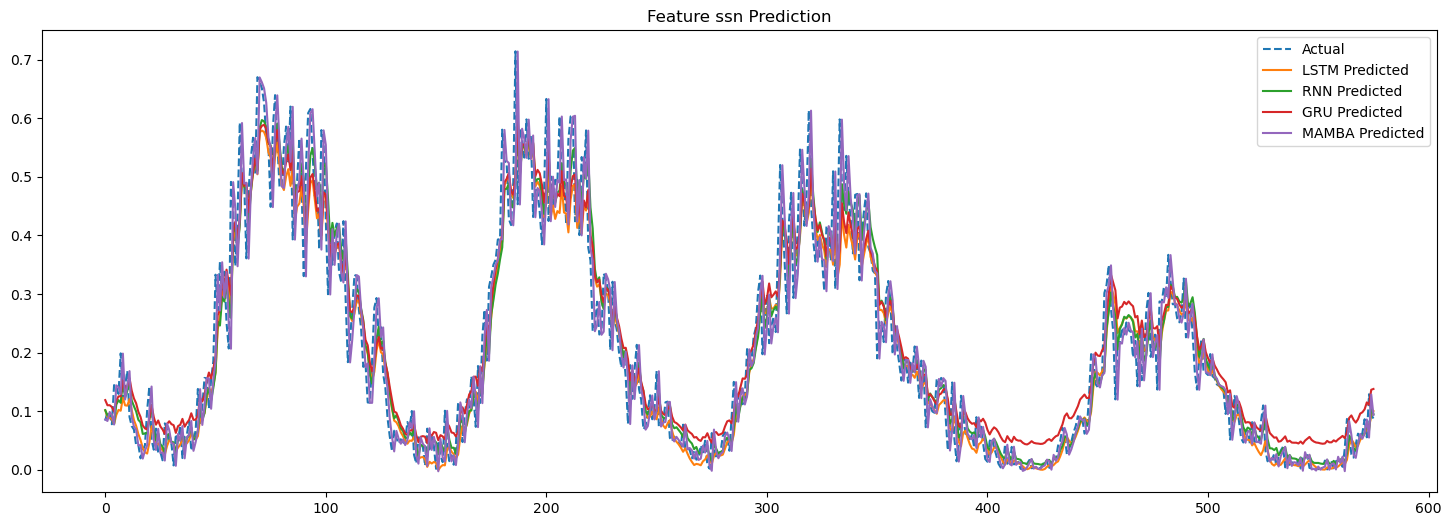

In [16]:
# PLOT PREDCTIONS

feature_idx = 0
plt.figure(figsize=(18, 6))
plt.plot(y_true[:, feature_idx], label="Actual", linestyle="dashed")
plt.plot(lstm_y_pred[:, feature_idx], label="LSTM Predicted")
plt.plot(rnn_y_pred[:, feature_idx], label="RNN Predicted")
plt.plot(gru_y_pred[:, feature_idx], label="GRU Predicted")
plt.plot(mamba_y_pred[0][:, -1, :][:, feature_idx], label="MAMBA Predicted")
plt.legend()
plt.title(f"Feature {df.columns[feature_idx]} Prediction")
plt.savefig('../plots/feature_prediction.png')
plt.show()

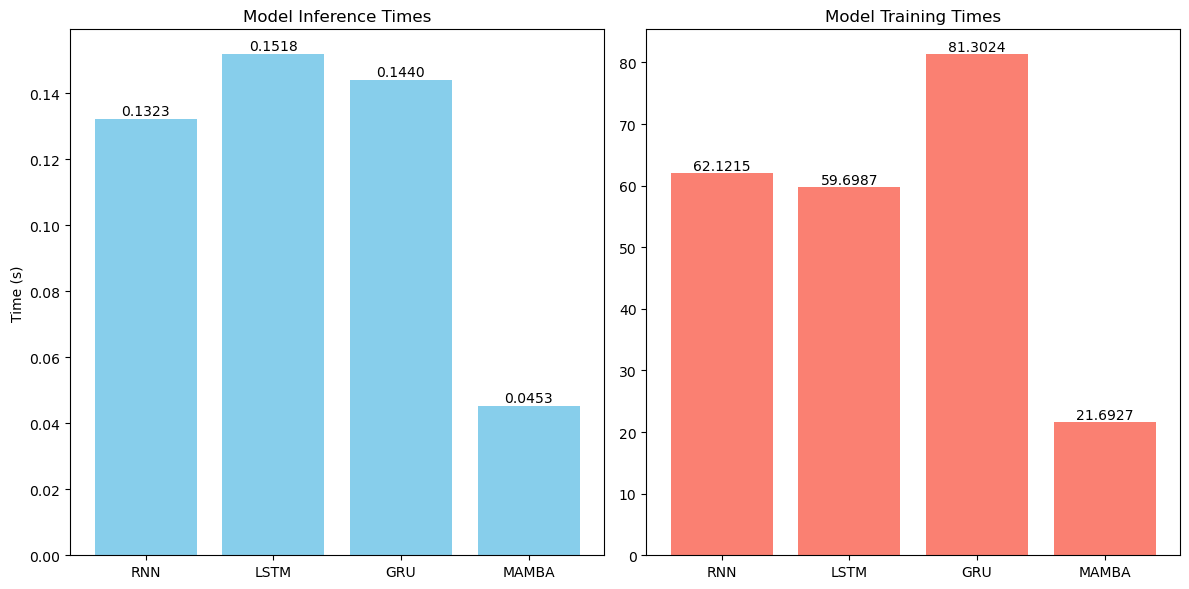

In [17]:
# PLOT EVALUATION AND TRAIN TIME AS BAR CHART

models = ["RNN", "LSTM", "GRU", "MAMBA"]

# Assume these variables have been defined with the corresponding times
eval_times = [lstm_eval_time, rnn_eval_time, gru_eval_time, mamba_eval_time]
train_times = [lstm_train_time, rnn_train_time, gru_train_time, mamba_train_time]

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Left subplot: Evaluation Times
axs[0].bar(models, eval_times, color='skyblue')
axs[0].set_ylabel("Time (s)")
axs[0].set_title("Model Inference Times")
# Add time values above each bar for evaluation times
for i, t in enumerate(eval_times):
    axs[0].text(i, t + 0.0003, f"{t:.4f}", ha='center', va='bottom')

# Right subplot: Training Times
axs[1].bar(models, train_times, color='salmon')
# axs[1].set_ylabel("Time (s)")
axs[1].set_title("Model Training Times")
# Add time values above each bar for training times
for i, t in enumerate(train_times):
    axs[1].text(i, t + 0.003, f"{t:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../plots/training_inference_time.png')
plt.show()

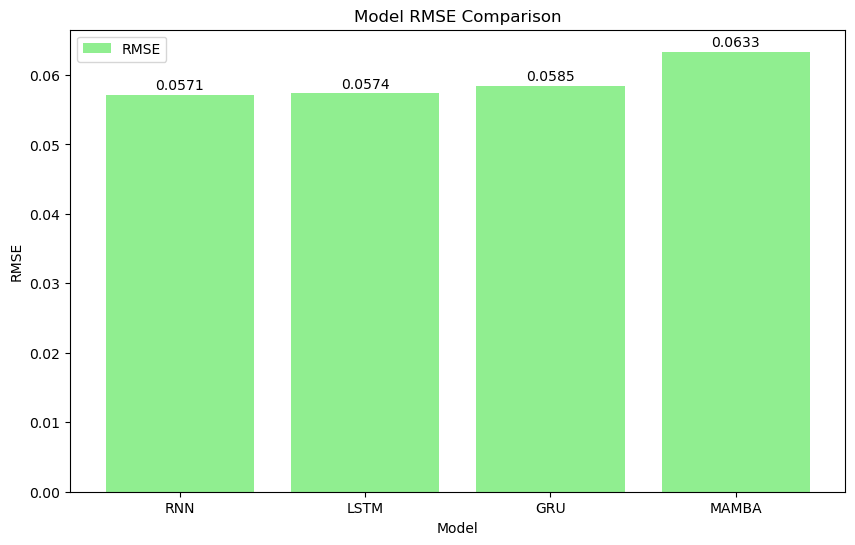

In [18]:
from sklearn.metrics import mean_squared_error

# Define the RMSE calculation function
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate RMSE for each model
lstm_rmse = calculate_rmse(y_true, lstm_y_pred)
rnn_rmse  = calculate_rmse(y_true, rnn_y_pred)
gru_rmse  = calculate_rmse(y_true, gru_y_pred)
mamba_rmse = calculate_rmse(y_true, mamba_y_pred[0][:, -1, :])

# Organize the RMSE scores in the desired order: ["RNN", "LSTM", "GRU", "MAMBA"]
models = ["RNN", "LSTM", "GRU", "MAMBA"]
rmse_scores = [rnn_rmse, lstm_rmse, gru_rmse, mamba_rmse]

# Define positions for the bars
x = np.arange(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, rmse_scores, color='lightgreen', label="RMSE")

plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Model RMSE Comparison")
plt.xticks(x, models)
plt.legend()

# Add RMSE values above each bar
for i, score in enumerate(rmse_scores):
    plt.text(i, score + 0.0003, f"{score:.4f}", ha='center', va='bottom')

plt.savefig('../plots/metric_scores.png')
plt.show()


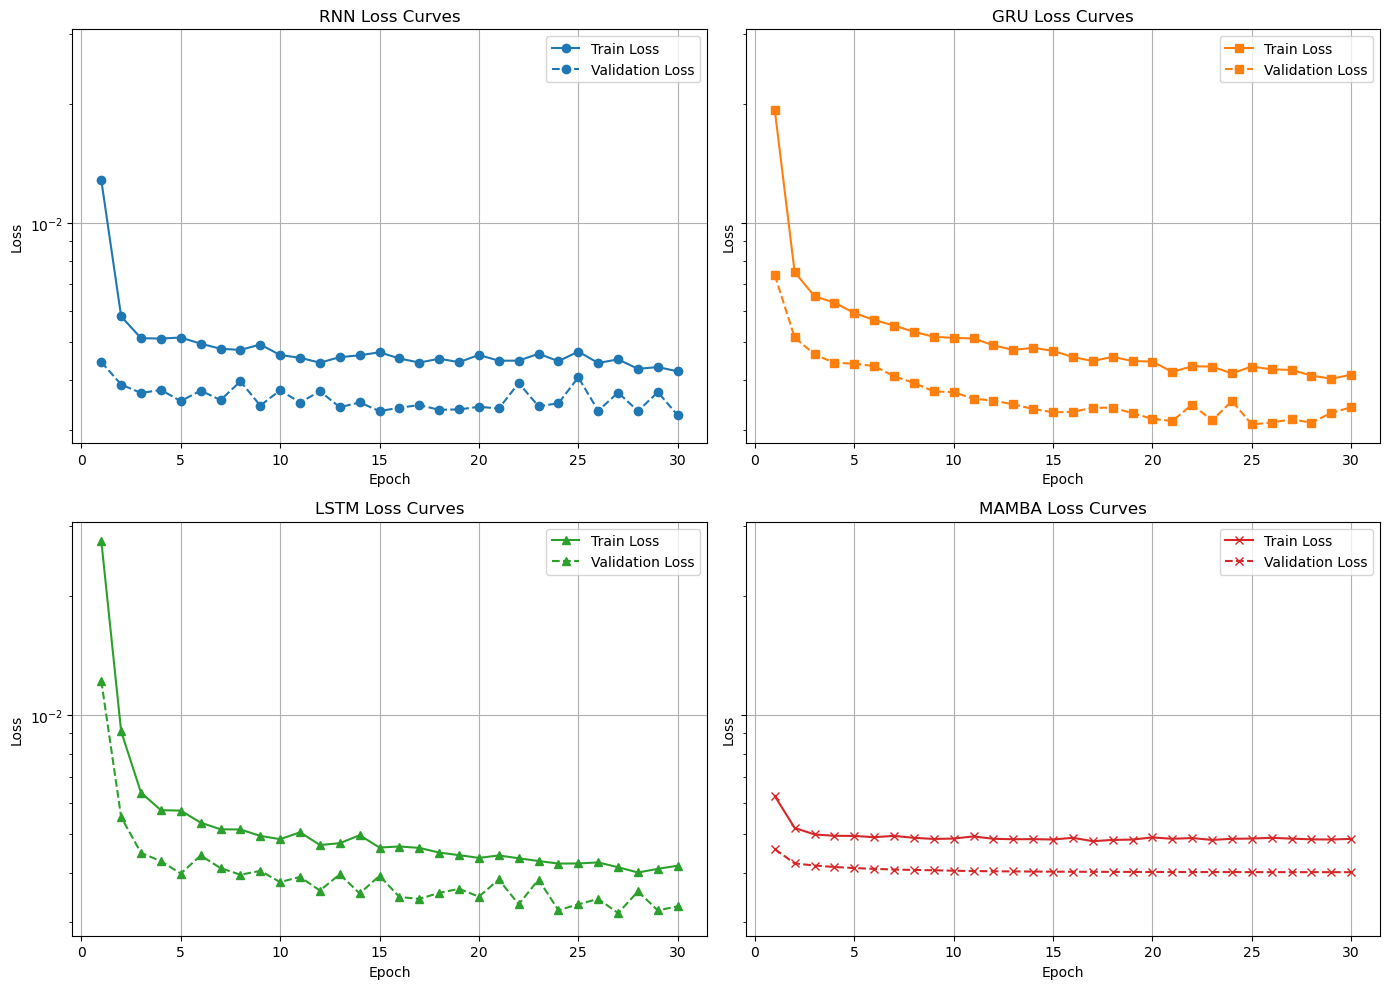

In [19]:
import matplotlib.pyplot as plt

# Assuming the loss history lists have the same length and epochs is defined as:
epochs = range(1, len(rnn_train_loss_history) + 1)  # or any of the loss histories

# Create subplots with shared y-axis across all plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# RNN subplot
axs[0, 0].plot(epochs, rnn_train_loss_history, marker='o', linestyle='-', label='Train Loss', color='tab:blue')
axs[0, 0].plot(epochs, rnn_test_loss_history, marker='o', linestyle='--', label='Validation Loss', color='tab:blue')
axs[0, 0].set_title("RNN Loss Curves")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_yscale('log')
axs[0, 0].grid(True)
axs[0, 0].legend()

# GRU subplot
axs[0, 1].plot(epochs, gru_train_loss_history, marker='s', linestyle='-', label='Train Loss', color='tab:orange')
axs[0, 1].plot(epochs, gru_test_loss_history, marker='s', linestyle='--', label='Validation Loss', color='tab:orange')
axs[0, 1].set_title("GRU Loss Curves")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].set_yscale('log')
axs[0, 1].grid(True)
axs[0, 1].legend()

# LSTM subplot
axs[1, 0].plot(epochs, lstm_train_loss_history, marker='^', linestyle='-', label='Train Loss', color='tab:green')
axs[1, 0].plot(epochs, lstm_test_loss_history, marker='^', linestyle='--', label='Validation Loss', color='tab:green')
axs[1, 0].set_title("LSTM Loss Curves")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_yscale('log')
axs[1, 0].grid(True)
axs[1, 0].legend()

# MAMBA subplot
axs[1, 1].plot(epochs, mamba_train_loss_history, marker='x', linestyle='-', label='Train Loss', color='tab:red')
axs[1, 1].plot(epochs, mamba_test_loss_history, marker='x', linestyle='--', label='Validation Loss', color='tab:red')
axs[1, 1].set_title("MAMBA Loss Curves")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].set_yscale('log')
axs[1, 1].grid(True)
axs[1, 1].legend()

plt.tight_layout()
plt.savefig('../plots/loss_curves.png')
plt.show()


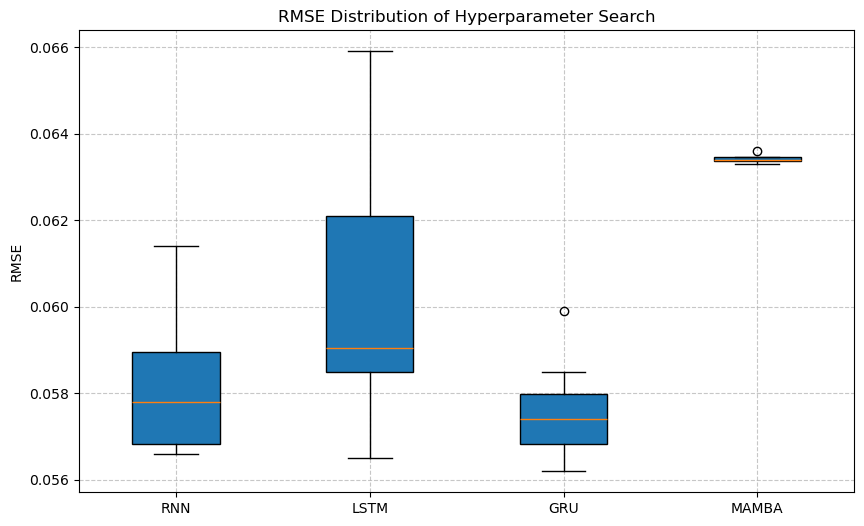

In [21]:
import matplotlib.pyplot as plt

# RMSE values for each model (from your table)
rnn_rmse = [0.0569, 0.0566, 0.0614, 0.0581, 0.0575, 0.0589, 0.0566, 0.0591]
lstm_rmse = [0.0587, 0.0621, 0.0582, 0.0586, 0.0594, 0.0659, 0.0565, 0.0621]
gru_rmse  = [0.0570, 0.0599, 0.0578, 0.0570, 0.0562, 0.0585, 0.0578, 0.0563]
mamba_rmse = [0.0633, 0.0634, 0.0636, 0.0634]

# Group the RMSE values in a list of lists
data = [rnn_rmse, lstm_rmse, gru_rmse, mamba_rmse]
labels = ["RNN", "LSTM", "GRU", "MAMBA"]

plt.figure(figsize=(10, 6))
plt.boxplot(data, tick_labels=labels, patch_artist=True)

plt.ylabel("RMSE")
plt.title("RMSE Distribution of Hyperparameter Search")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('../plots/hyperparameter_search.png')
plt.show()
